# SQL
Using PyGresQL to experiment with SQL queries.

## Requirements
* Postgres running on localhost
* Working login to local postgres server for current user
* Database with the same number as the current user's username.
* data file: '/data/pp-2016.csv'

## Setup
* Generate a database from the UK land registry house prices paid for the year to date
* Dataset is available here: https://data.gov.uk/dataset/land-registry-monthly-price-paid-data
* The column headers are listed here: https://www.gov.uk/guidance/about-the-price-paid-data
* The dataset is fairly simple, and is good for experimenting with basic select statements without requiring complicated joins.

The data is in CSV format with the following columns:

|Column|Description|SQL Data Type|
|------|-----------|-------------|
|Transaction Unique Identifier|A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.|Remove (N/A)|
|Price|Sale price stated on the transfer deed.||
|Date of Transfer|Date when the sale was completed, as stated on the transfer deed.||
|Postcode|This is the postcode used at the time of the original transaction. Note that postcodes can be reallocated and these changes are not reflected in the Price Paid Dataset.||
|Property Type|D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other ||
|OldNew|Indicates the age of the property and applies to all price paid transactions, residential and non-residential. Y = a newly built property, N = an established residential building||
|Duration|Relates to the tenure: F = Freehold, L= Leasehold etc.||
|PAON|Primary Addressable Object Name. If there is a sub-building for example the building is divided into flats, see Secondary Addressable Object Name (SAON).|Store addresses in a single text column, as we have postcode which is more useful.|
|SAON|Secondary Addressable Object Name. If there is a sub-building, for example the building is divided into flats, there will be a SAON.||
|Street|||
|Locality|||
|TownCity|||
|District|||
|County|||
|PPD|Indicates the type of Price Paid transaction. A = Standard Price Paid entry, includes single residential property sold for full market value. B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals.||
|RecordStatus|Indicates additions, changes and deletions to the records.(see guide below). A = Addition C = Change D = Delete.|||


### Notes on Inputing the Data
* Each record has a GUID as an identifier, we probably don't need to use these as the primary key in the database, instead we can just create an auto incrementing int based column. GUIDs are useful in some situations (e.g. if you need to generate the record outside of the database and add it afterwards)  but they have performance implications, as they do not index well. Therefore, I'll dump the GUIDs and just use the serial data type to add unique ids on insertion.
* Addresses are largely irrelavent, so just store the address as one large string.

In [4]:
import pgdb

create_property_type_sql = ('CREATE TABLE property_type '
                                '(id serial PRIMARY KEY,'
                                ' code text,'
                                ' description text)')

create_duration_sql = ('CREATE TABLE duration '
                              '(id serial PRIMARY KEY,'
                              ' code text,'
                              ' description text)')

transaction_type_sql = ('CREATE TABLE transaction_type '
                           '(id serial PRIMARY KEY,'
                           ' code text,'
                           ' description text)')

create_house_prices_sql = ('CREATE TABLE house_prices' 
                                '(id serial PRIMARY KEY,' 
                                ' price int,'
                                ' transfer_date date,'
                                ' postcode text,'
                                ' property_type_id integer REFERENCES property_type(id) ON DELETE RESTRICT,'
                                ' new_build boolean,'
                                ' duration_id integer REFERENCES duration(id) ON DELETE RESTRICT,'
                                ' address text,' 
                                ' transaction_type_id integer REFERENCES transaction_type(id) ON DELETE RESTRICT)')


def drop_if_exists(cursor, table_name):
    result = cursor.execute("SELECT to_regclass('%s');" % (table_name,))
    exists = (result.fetchone())[0]

    if exists:
        cursor.execute('DROP TABLE "%s";' % (table_name,))

        
def setup_database(cursor):
    # Get rid of existing data (if any)
    drop_if_exists(cursor, 'house_prices')
    drop_if_exists(cursor, 'property_type')
    drop_if_exists(cursor, 'duration')
    drop_if_exists(cursor, 'transaction_type')

    cursor.execute(create_property_type_sql)
    cursor.executemany(
        'INSERT INTO property_type (code, description) VALUES (%s, %s)', 
        (('D','Detached'), 
         ('S','Semi-Detached'), 
         ('T','Terraced'), 
         ('F','Flats/Maisonettes'),
         ('O','Other'))
    )
    cursor.execute(create_duration_sql)
    cursor.executemany(
        'INSERT INTO duration (code, description) VALUES (%s, %s)',
        (('F', 'Freehold'),
         ('L', 'Leasehold'))
    )
    cursor.execute(transaction_type_sql)
    cursor.executemany(
        'INSERT INTO transaction_type (code, description) VALUES (%s, %s)',
        (('A', 'Standard'),
         ('B', 'Additional'))
    )
    cursor.execute(create_house_prices_sql)

    
def add_house_price_record(cursor, raw_data):
    price = raw_data[1]
    transfer_date = raw_data[2].split(' ')[0]
    postcode = raw_data[3]
    prop_type = raw_data[4]
    new_build = raw_data[5] == 'Y'
    duration = raw_data[6]
    address = ",".join(raw_data[7:14])
    transaction_type = raw_data[14]
    
    cursor.execute(
        (
            'WITH ins (price,' 
                       'transfer_date, '
                       'post_code,'
                       'property_code,'
                       'new_build, '
                       'duration_code, '
                       'address, '
                       'transaction_type_code) AS '
             '(VALUES (%d, %s, %s, %s, %s, %s, %s, %s)) '   
             'INSERT INTO house_prices ('
                 'price, '
                 'transfer_date, '
                 'postcode, '
                 'property_type_id, '
                 'new_build, '
                 'duration_id, '
                 'address, '
                 'transaction_type_id'
             ') '
             'SELECT '
                 'ins.price, '
                 'ins.transfer_date::date, '
                 'ins.post_code, '
                 'property_type.id, '
                 'ins.new_build::boolean, '
                 'duration.id, '
                 'ins.address, '
                 'transaction_type.id '
             'FROM '
                 'ins JOIN property_type ON ins.property_code = property_type.code '
                 '    JOIN duration ON ins.duration_code = duration.code '
                 '    JOIN transaction_type ON ins.transaction_type_code = transaction_type.code'
        ),
        (
            int(price),
            transfer_date,
            postcode,
            prop_type,
            str(new_build),
            duration,
            address,
            transaction_type
        )
    )    
    
import csv
def import_data(cursor):
    with open('../data/pp-2016.csv') as data_file:
        reader = csv.reader(data_file, delimiter=',', quotechar='"')

        i = 0
        for row in reader:
            # Ignore updates and deletions
            if row[-1] != 'A':
                continue
                
            add_house_price_record(cursor, row)
            i += 1
            if i % 10000 == 0:
                print('Processed %d records' % i)
    
with pgdb.connect('localhost:james', user='james', password='dev') as conn:
    with conn.cursor() as cursor:            
        setup_database(cursor)
        conn.commit()
        import_data(cursor)
        cursor.execute('SELECT COUNT(*) from house_prices;')
        print(cursor.fetchone())
    conn.commit()

Processed 10000 records
Processed 20000 records
Processed 30000 records
Processed 40000 records
Processed 50000 records
Processed 60000 records
Processed 70000 records
Processed 80000 records
Processed 90000 records
Processed 100000 records
Processed 110000 records
Processed 120000 records
Processed 130000 records
Processed 140000 records
Processed 150000 records
Processed 160000 records
Processed 170000 records
Processed 180000 records
Processed 190000 records
Processed 200000 records
Processed 210000 records
Processed 220000 records
Processed 230000 records
Processed 240000 records
Row(count=249092L)


## Querying the Data

### Average house price across all sales

In [2]:
import pgdb

def query(sql):
    with pgdb.connect('localhost:james', user='james', password='dev') as conn:
        with conn.cursor() as cursor:            
            cursor.execute(sql)
            return cursor.fetchall()

In [9]:
query('SELECT AVG(price) from house_prices;')

[Row(avg=Decimal('294095.648278547685'))]

In [26]:
# Find minimum price paid for a house
query("SELECT MIN(price) FROM house_prices, transaction_type " 
          "WHERE transaction_type.id = house_prices.transaction_type_id AND "
                "transaction_type.code = 'A'")

[Row(min=1)]

In [11]:
# Select rows that have the minimum price value using a nested query
query("SELECT * FROM house_prices "
          "WHERE price = (SELECT MIN(price) FROM house_prices);")

[Row(id=83952, price=1, transfer_date=datetime.date(2016, 2, 17), postcode='HA0 3NG', property_type_id=3, new_build=False, duration_id=2, address='191A,,EAST LANE,,WEMBLEY,BRENT,GREATER LONDON', transaction_type_id=1)]

### House price distribution

In [29]:
def plot_histo(data):
    bins = [str(r[0]) for r in results]
    counts = [r[1] for r in results]
    return plot.bar(bins, counts)  

<Container object of 630 artists>

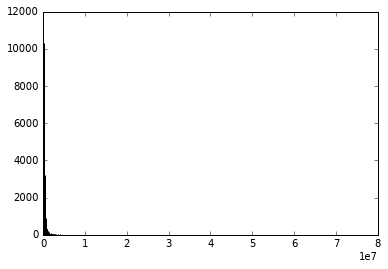

In [16]:
%matplotlib inline
import matplotlib.pyplot as plot
# Show the distribution of house prices. To do this we need to generate a histogram of house prices.
# See http://stackoverflow.com/a/10363145
results = query("SELECT ROUND(price, -4) AS bucket, COUNT(*) AS count FROM house_prices GROUP BY bucket ORDER BY bucket;")
plot_histo(results)

<Container object of 101 artists>

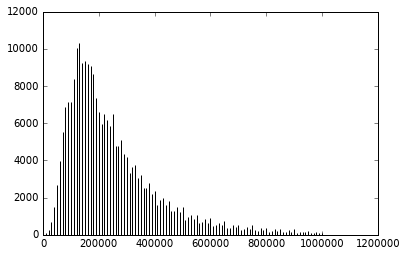

In [17]:
# There are couple of highly priced outliers which result in a huge range for the x axis, 
# to filter these out, we can observe that most sales are for < £5e6, but lets look at 
# sales below £1e6
results = query("SELECT ROUND(price, -4) AS bucket, COUNT(*) AS count "
                "FROM house_prices "
                "WHERE price < 1e6"
                "GROUP BY bucket "
                "ORDER BY bucket;")
plot_histo(results)

### Sales over time
* Whats the distrubtions of sales over time (let's say on a month by month basis)?

['2016-01-01 00:00:00+00:00', '2016-02-01 00:00:00+00:00', '2016-03-01 00:00:00+00:00', '2016-04-01 00:00:00+00:00']
[61892L, 64662L, 104187L, 18351L]


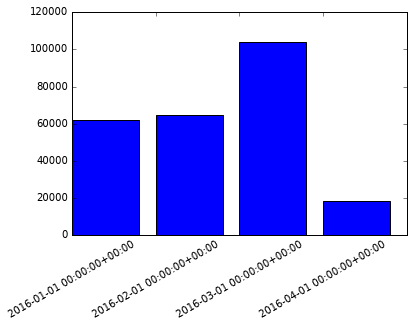

In [57]:
import pytz

# The best way to do this seems to be to cast the month portion of the date to a string and then group by it.
results = query("SELECT date_trunc('month', transfer_date) AS month, COUNT(*) " 
                "FROM house_prices " 
                "GROUP BY month "
                "ORDER BY month "
                "LIMIT 10;")
months = [str(r[0].replace(tzinfo=pytz.UTC)) for r in results]
print months
counts = [r[1] for r in results]
print counts
ax = plot.subplot(111)
ax.bar(range(0, len(months)), counts)
plot.xticks(xrange(0, len(months)), months, rotation=30)
plot.show()


### Average house price per postcode

In [64]:
# which postcode has the lowest avg price?
results = query("SELECT postcode, AVG(price) AS avg_price "
                "FROM house_prices "
                "WHERE price > 50000"
                "GROUP BY postcode "
                "ORDER BY avg_price "
                "LIMIT 10;")
print(results)

[Row(postcode='SA10 9BT', avg_price=Decimal('50050.000000000000')), Row(postcode='LA14 1DG', avg_price=Decimal('50300.000000000000')), Row(postcode='WA8 4SX', avg_price=Decimal('50400.000000000000')), Row(postcode='DN37 9NA', avg_price=Decimal('50500.000000000000')), Row(postcode='DL3 6RA', avg_price=Decimal('50500.000000000000')), Row(postcode='DL4 2JG', avg_price=Decimal('50500.000000000000')), Row(postcode='DH6 3QU', avg_price=Decimal('50500.000000000000')), Row(postcode='CA14 3DD', avg_price=Decimal('50500.000000000000')), Row(postcode='BD7 3NH', avg_price=Decimal('50500.000000000000')), Row(postcode='CF32 7LD', avg_price=Decimal('50500.000000000000'))]


## Refs
* https://www.pgcon.org/2013/schedule/attachments/269_tour-of-postgresql-data-types.pdf
* http://dba.stackexchange.com/questions/322/what-are-the-drawbacks-with-using-uuid-or-guid-as-a-primary-key
* https://rclayton.silvrback.com/do-you-really-need-a-uuid-guid
* http://kccoder.com/mysql/uuid-vs-int-insert-performance/